# Nvidia Univarite Stock Forecasat with LSTM

# Install Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the Data

In [2]:
df = pd.read_csv("/content/NVidia_stock_history.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1999-01-22 00:00:00-05:00,0.040129,0.044786,0.035590,0.037621,2714688000,0.0,0.0
1,1999-01-25 00:00:00-05:00,0.040607,0.042039,0.037621,0.041562,510480000,0.0,0.0
2,1999-01-26 00:00:00-05:00,0.042039,0.042876,0.037740,0.038337,343200000,0.0,0.0
3,1999-01-27 00:00:00-05:00,0.038457,0.039412,0.036307,0.038218,244368000,0.0,0.0
4,1999-01-28 00:00:00-05:00,0.038218,0.038457,0.037859,0.038098,227520000,0.0,0.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
6437,2024-08-22 00:00:00-04:00,130.020004,130.750000,123.099998,123.739998,376189100,0.0,0.0
6438,2024-08-23 00:00:00-04:00,125.860001,129.600006,125.220001,129.369995,323230300,0.0,0.0
6439,2024-08-26 00:00:00-04:00,129.570007,131.259995,124.370003,126.459999,331964700,0.0,0.0
6440,2024-08-27 00:00:00-04:00,125.050003,129.199997,123.879997,128.300003,301726100,0.0,0.0
6441,2024-08-28 00:00:00-04:00,128.119995,128.330002,122.639999,125.175003,241795982,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442 entries, 0 to 6441
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6442 non-null   object 
 1   Open          6442 non-null   float64
 2   High          6442 non-null   float64
 3   Low           6442 non-null   float64
 4   Close         6442 non-null   float64
 5   Volume        6442 non-null   int64  
 6   Dividends     6442 non-null   float64
 7   Stock Splits  6442 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 402.8+ KB


In [13]:
# Convert 'Date' to datetime, handling timezone information if present
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Extract only the date and format it as YYYY-MM-DD
df['Date'] = df['Date'].dt.date

print(df)

            Date        Open        High         Low       Close      Volume  \
0     1999-01-22    0.040129    0.044786    0.035590    0.037621  2714688000   
1     1999-01-25    0.040607    0.042039    0.037621    0.041562   510480000   
2     1999-01-26    0.042039    0.042876    0.037740    0.038337   343200000   
3     1999-01-27    0.038457    0.039412    0.036307    0.038218   244368000   
4     1999-01-28    0.038218    0.038457    0.037859    0.038098   227520000   
...          ...         ...         ...         ...         ...         ...   
6437  2024-08-22  130.020004  130.750000  123.099998  123.739998   376189100   
6438  2024-08-23  125.860001  129.600006  125.220001  129.369995   323230300   
6439  2024-08-26  129.570007  131.259995  124.370003  126.459999   331964700   
6440  2024-08-27  125.050003  129.199997  123.879997  128.300003   301726100   
6441  2024-08-28  128.119995  128.330002  122.639999  125.175003   241795982   

      Dividends  Stock Splits  
0      

In [14]:
# Create a date range for filtering
start_date = '2023-07-01'
end_date = '2024-08-28'

# Convert 'date' column to datetime if it isn't already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(filtered_df)


           Date        Open        High         Low       Close     Volume  \
6150 2023-07-03   42.504272   42.885158   42.189368   42.400303  198209000   
6151 2023-07-05   42.122388   43.164076   42.072404   42.304337  323618000   
6152 2023-07-06   41.831479   42.166378   41.333627   42.090401  303582000   
6153 2023-07-07   42.309331   43.201066   42.167375   42.490276  355881000   
6154 2023-07-10   42.644232   42.798185   41.636531   42.167374  353908000   
...         ...         ...         ...         ...         ...        ...   
6437 2024-08-22  130.020004  130.750000  123.099998  123.739998  376189100   
6438 2024-08-23  125.860001  129.600006  125.220001  129.369995  323230300   
6439 2024-08-26  129.570007  131.259995  124.370003  126.459999  331964700   
6440 2024-08-27  125.050003  129.199997  123.879997  128.300003  301726100   
6441 2024-08-28  128.119995  128.330002  122.639999  125.175003  241795982   

      Dividends  Stock Splits  
6150        0.0           0.0  

In [15]:
df = filtered_df.copy()

In [16]:
# Preprocessing data (focus on 'Close' price)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Close']].values

# Preprocess the Data

In [17]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [18]:
# Prepare training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [19]:
# Create dataset matrix for LSTM
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [20]:
look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [21]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM Model

In [22]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model

In [25]:
# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0805
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0113
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━

# Prediction

In [26]:
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step


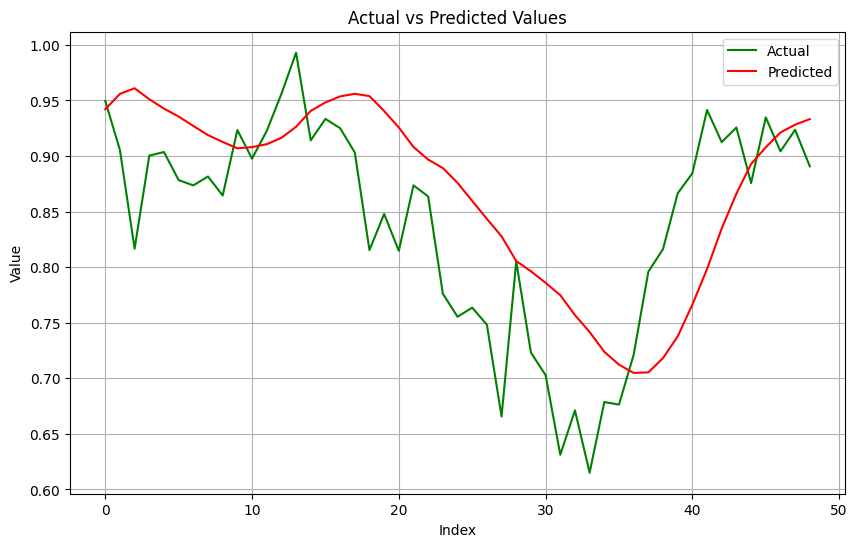

In [31]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Plot the test data
plt.plot(y_test, color='green', label='Actual')

# Plot the predicted data
plt.plot(y_pred, color='red', label='Predicted')

# Add titles and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show grid lines for better readability
plt.grid(True)

# Display the plot
plt.show()


# Next 30 Days Forecasting

In [32]:
# Forecasting the next 30 days
def forecast_next_days(model, last_sequence, days=30):
    forecasted = []
    current_sequence = last_sequence

    for _ in range(days):
        predicted_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        forecasted.append(predicted_value)
        current_sequence = np.append(current_sequence[1:], predicted_value).reshape(-1, 1)

    return forecasted



In [33]:
# Use the last available data point for forecasting
last_sequence = X_test[-1]
predicted_values = forecast_next_days(model, last_sequence, days=30)

# Inverse scale the predicted values
predicted_values_rescaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

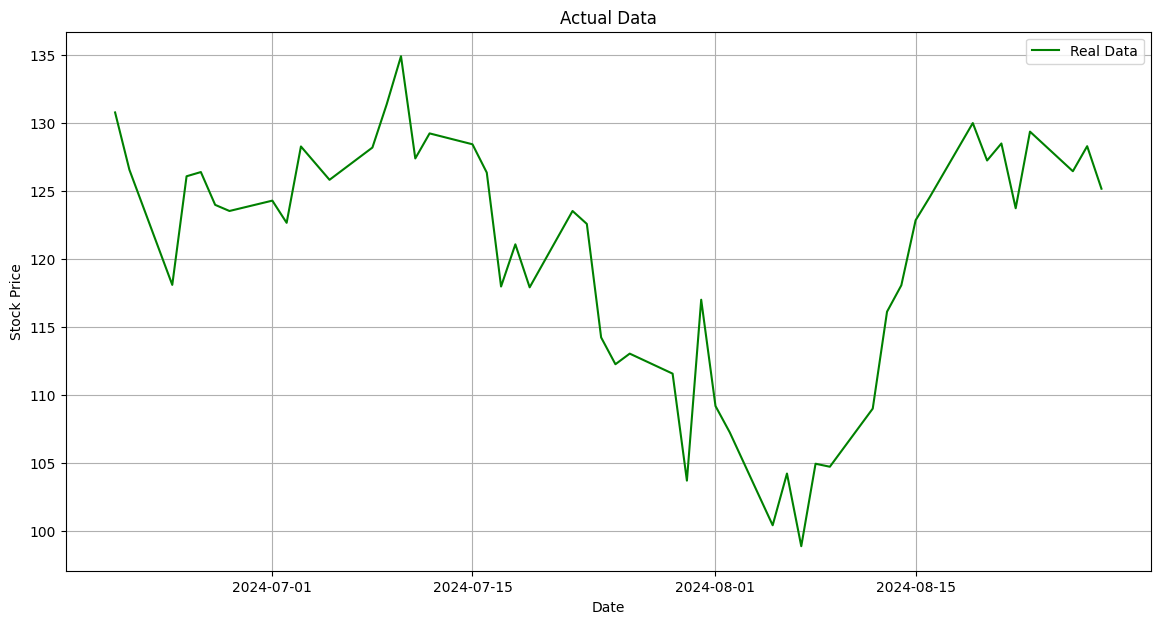

In [34]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')

plt.title('Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

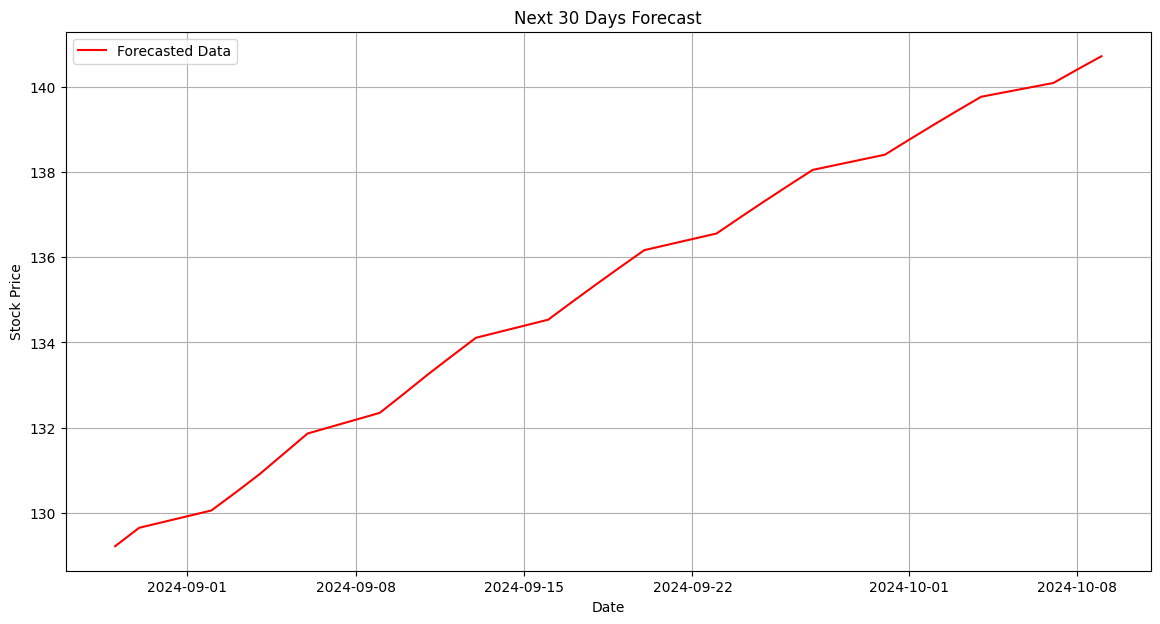

In [36]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(pd.date_range(df.index[-1], periods=31, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

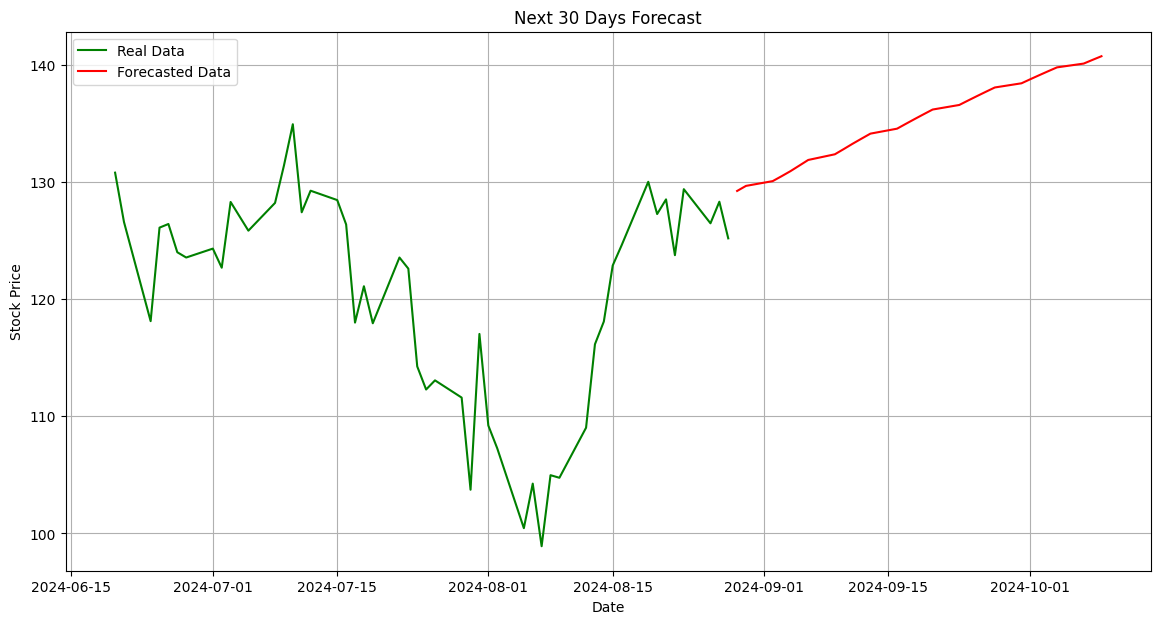

In [37]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

# Next 90 Days Forecast

In [38]:
# Use the last available data point for forecasting
last_sequence = X_test[-1]
predicted_values = forecast_next_days(model, last_sequence, days=90)

# Inverse scale the predicted values
predicted_values_rescaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

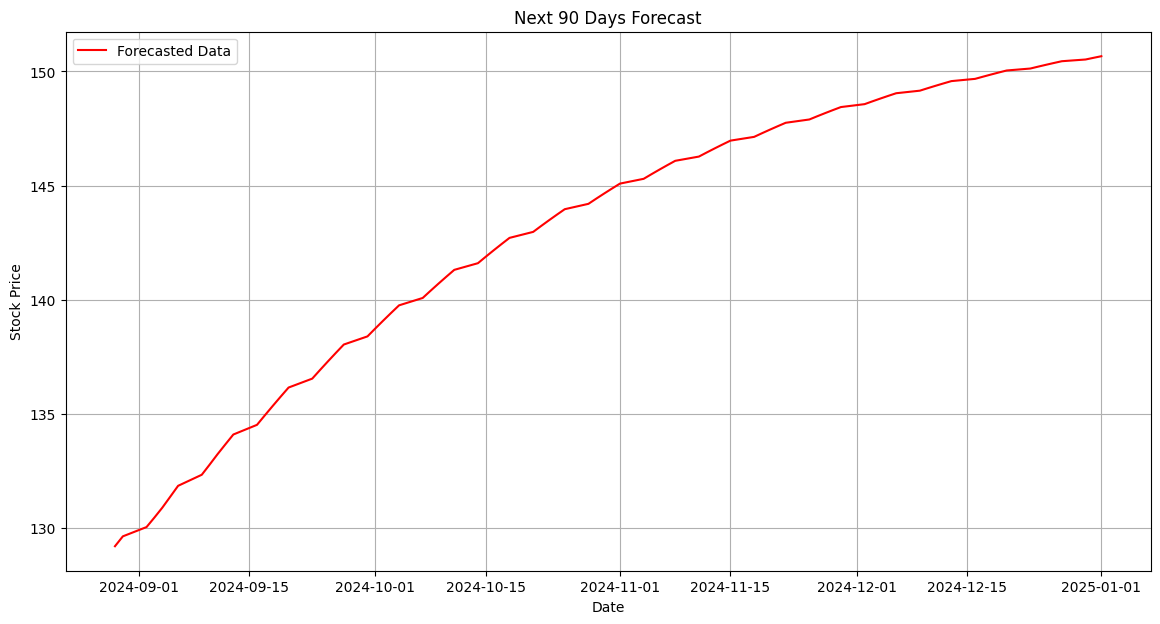

In [39]:
# Plot the results
plt.figure(figsize=(14,7))

plt.plot(pd.date_range(df.index[-1], periods=91, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

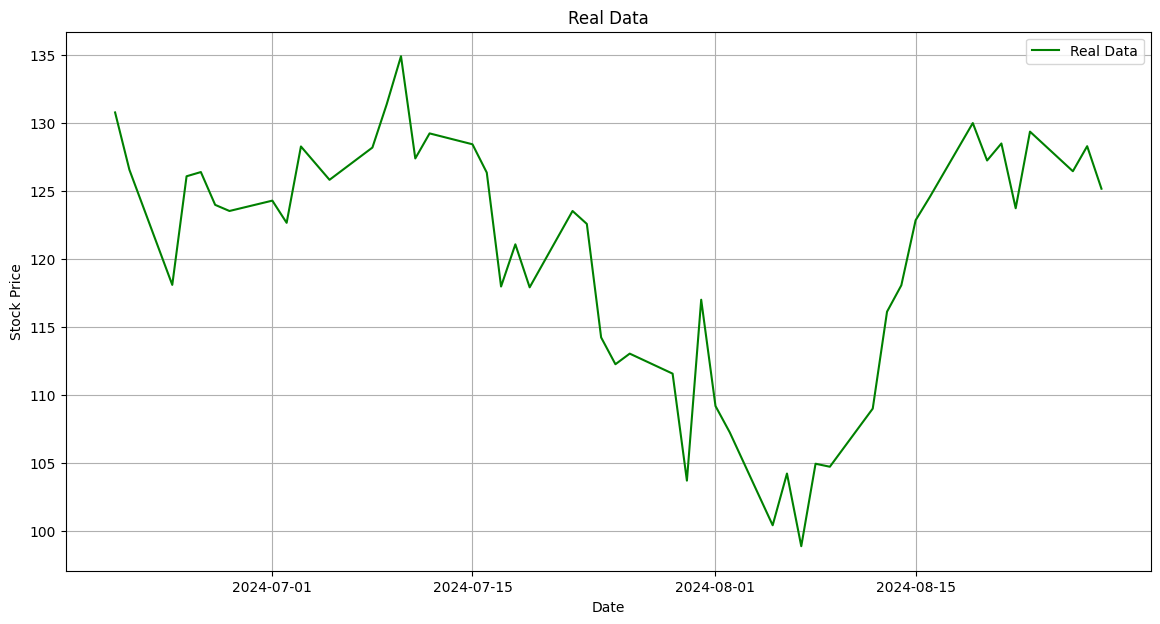

In [40]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.title('Real Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()

plt.show()

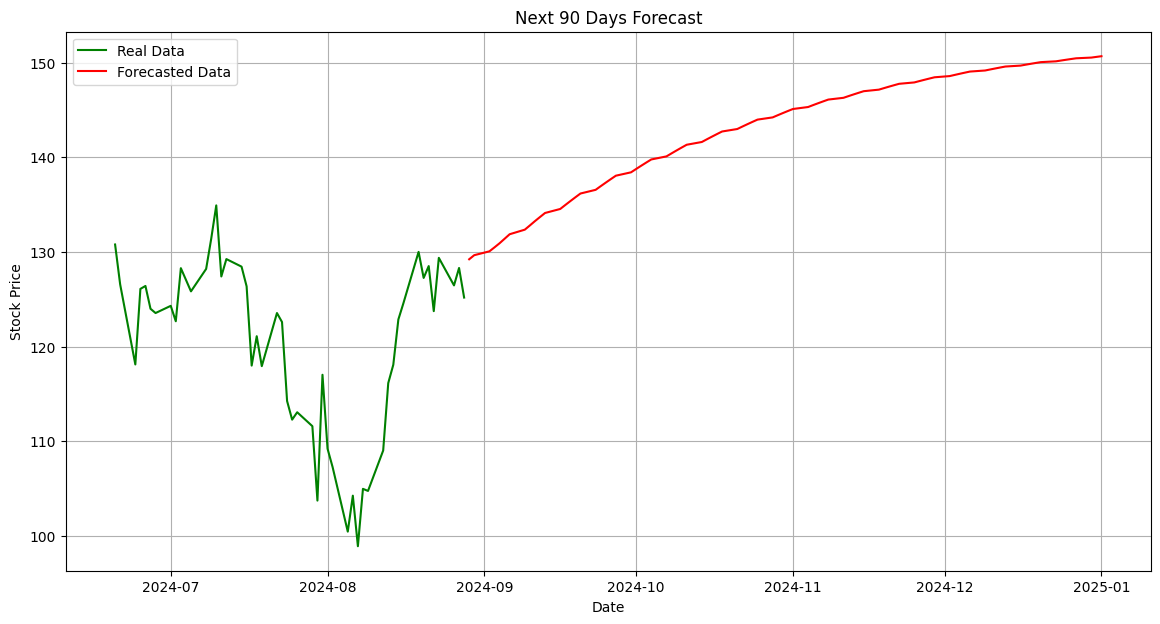

In [41]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(test_data[look_back:]), label='Real Data',color='green')
plt.plot(pd.date_range(df.index[-1], periods=91, freq='B')[1:], predicted_values_rescaled, label='Forecasted Data',color='red')
plt.title('Next 90 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()